In [27]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [17]:
DATA_FOLDER = "/mnt/thau03a/datasets/c1_muse_perception"

In [18]:
labels = pd.read_csv(f"{DATA_FOLDER}/labels.csv")
partitions = pd.read_csv(f"{DATA_FOLDER}/metadata/partition.csv")
partitions.Partition.value_counts()

Partition
test     60
train    59
devel    58
Name: count, dtype: int64

In [19]:
train_labels = labels[labels["subj_id"].isin(partitions[partitions["Partition"] == "train"]["Id"])]
devel_labels = labels[labels["subj_id"].isin(partitions[partitions["Partition"] == "devel"]["Id"])]
test_labels = labels[labels["subj_id"].isin(partitions[partitions["Partition"] == "test"]["Id"])]

In [20]:
pca_2d = PCA(n_components=2)
pca_2d.fit(train_labels.drop(columns="subj_id"))

PCA(n_components=2)

In [21]:
PC1_DEVEL_PREDS_PATH = '../results/2024-06-04_17-05-04-178/prediction_muse/perception/PC1/RNN_2024-06-04-17-05_[vit-fer]_[256_2_False_64]_[0.0005_256]/predictions_devel.csv'
PC2_DEVEL_PREDS_PATH = '../results/2024-06-04_17-04-44-484/prediction_muse/perception/PC2/RNN_2024-06-04-17-04_[vit-fer]_[256_2_False_64]_[0.0005_256]/predictions_devel.csv'

devel_preds_pc1 = pd.read_csv(PC1_DEVEL_PREDS_PATH)
devel_preds_pc1 = devel_preds_pc1.rename(columns={"meta_col_0": "subj_id", "prediction": "PC1"})

devel_preds_pc2 = pd.read_csv(PC2_DEVEL_PREDS_PATH)
devel_preds_pc2 = devel_preds_pc2.rename(columns={"meta_col_0": "subj_id", "prediction": "PC2"})

devel_preds_pca = pd.merge(devel_preds_pc1, devel_preds_pc2.drop(columns="label"), on="subj_id")
devel_preds_pca.head()

,subj_id,PC1,label,PC2
0,9,-0.097996,-0.138677,-0.044195
1,10,-0.041680,-0.089853,0.054052
2,13,-0.066455,0.067850,0.021833
3,20,-0.064505,-0.122741,0.105467
4,25,-0.106723,-0.408625,0.048462


In [22]:
devel_labels_pca = pca_2d.transform(devel_labels.drop(columns="subj_id"))
devel_labels_pca = pd.DataFrame(devel_labels_pca, columns=["PC1", "PC2"])
devel_labels_pca["subj_id"] = devel_labels["subj_id"].values
devel_labels_pca.head()

,PC1,PC2,subj_id
0,-0.138677,-0.017686,9
1,-0.089853,0.075267,10
2,0.067850,-0.153043,13
3,-0.122741,0.228385,20
4,-0.408625,-0.234087,25


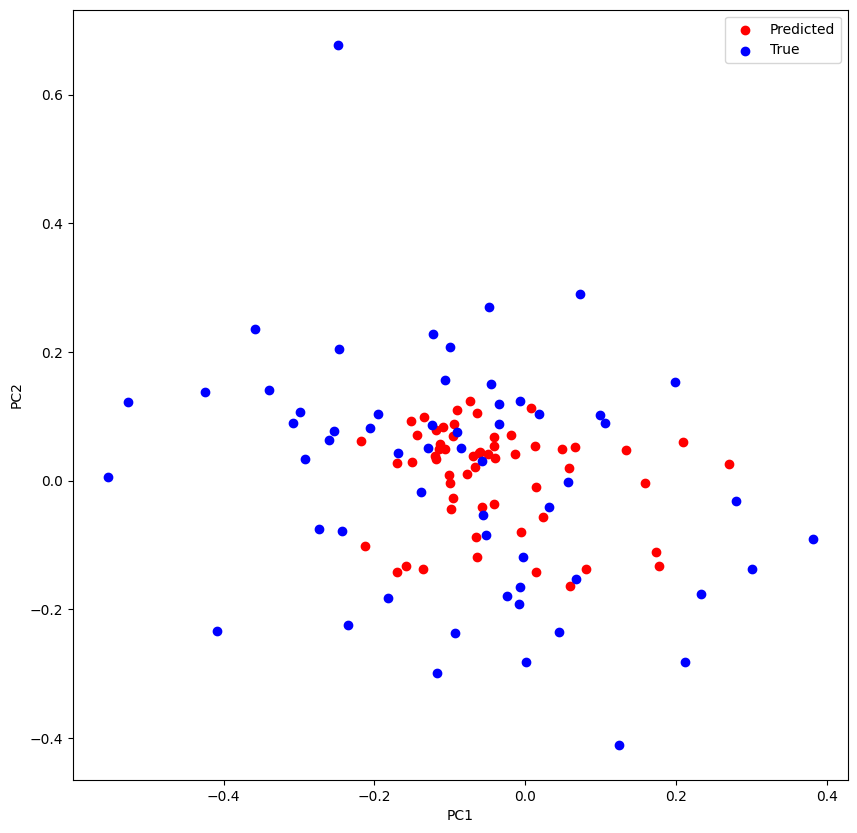

In [23]:
# Scatter plot of predicted and true pca values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(devel_preds_pca["PC1"], devel_preds_pca["PC2"], c="red", label="Predicted")
plt.scatter(devel_labels_pca["PC1"], devel_labels_pca["PC2"], c="blue", label="True")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [26]:
devel_preds = pca_2d.inverse_transform(devel_preds_pca.drop(columns=["subj_id","label"]))
devel_preds["subj_id"] = devel_preds_pca["subj_id"].values

In [29]:
devel_labels.drop(columns="subj_id").columns

Index(['aggressive', 'arrogant', 'attractive', 'charismatic', 'competitive',
       'dominant', 'enthusiastic', 'expressive', 'friendly', 'leader_like',
       'likeable', 'naive', 'assertiv', 'confident', 'independent', 'risk',
       'sincere', 'collaborative', 'kind', 'warm', 'good_natured'],
      dtype='object')

In [32]:
skip_columns = ["attractive", "charismatic", "competitive", "expressive", "naive"]

# Calculate the Mean Squared Error between the predicted and actual labels
mse = {}
for i, var in enumerate(devel_labels.drop(columns="subj_id").columns):
    if var in skip_columns:
        continue
    mse[var] = mean_squared_error(devel_labels[var], devel_preds[i])

mse = pd.Series(mse)
print(mse)
print(f"Mean MSE: {mse.mean()}")


# Calculate the Pearson correlation between the predicted and actual labels for each of the variables
correlations = {}
for i, var in enumerate(devel_labels.drop(columns="subj_id").columns):
    if var in skip_columns:
        continue
    correlation = pearsonr(devel_labels[var], devel_preds[i])[0]
    correlations[var] = correlation

correlations = pd.Series(correlations)
print(correlations)

# Mean correlation
mean_correlation = correlations.mean()
print(f"Mean Pearson Correlation: {mean_correlation}")

aggressive       0.006589
arrogant         0.004156
dominant         0.004104
enthusiastic     0.008802
friendly         0.005653
leader_like      0.003326
likeable         0.005096
assertiv         0.004281
confident        0.003746
independent      0.001991
risk             0.003637
sincere          0.003598
collaborative    0.003452
kind             0.004580
warm             0.005392
good_natured     0.004716
dtype: float64
Mean MSE: 0.0045699514181613225
aggressive       0.418947
arrogant         0.562575
dominant         0.363454
enthusiastic     0.317199
friendly         0.320503
leader_like      0.369897
likeable         0.304278
assertiv         0.279373
confident        0.314092
independent      0.389081
risk             0.308642
sincere          0.262466
collaborative    0.272073
kind             0.260671
warm             0.276956
good_natured     0.371489
dtype: float64
Mean Pearson Correlation: 0.33698098214329686
